In [1]:
import logging
import numpy as np
import pandas as pd
import torch
import json
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch.nn as nn
import matplotlib.pyplot as plt

c:\Users\mdjub\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
cuda_available = torch.cuda.is_available()
if cuda_available:
    print(f"CUDA is available! Device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")


CUDA is not available. Using CPU.


In [3]:
# Set up logging
logging.basicConfig(level=logging.INFO)

# Load the training dataset
train_file_path = "train.json"  # Replace with your training file path
with open(train_file_path, "r", encoding="utf-8") as f:
    train_data = json.load(f)

# Load the test dataset
test_file_path = "test.json"  # Replace with your test file path
with open(test_file_path, "r", encoding="utf-8") as f:
    test_data = json.load(f)

# Convert to DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

# Map labels to integers
label_mapping = {"N": 0, "O": 1}  # Adjust based on your dataset
train_df["label"] = train_df["offensive_gold"].map(label_mapping)
test_df["label"] = test_df["offensive_gold"].map(label_mapping)

# Initialize the Bangla-BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

# Preprocessing function
def preprocess_data(df, tokenizer, max_length=128):
    texts = df["text"].tolist()
    labels = df["label"].tolist()

    encodings = tokenizer(
        texts,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    )

    input_ids = encodings["input_ids"]
    attention_masks = encodings["attention_mask"]
    labels_tensor = torch.tensor(labels)

    return input_ids, attention_masks, labels_tensor

# Preprocess the training and test data
train_input_ids, train_attention_masks, train_labels_tensor = preprocess_data(train_df, tokenizer)
test_input_ids, test_attention_masks, test_labels_tensor = preprocess_data(test_df, tokenizer)

c:\Users\mdjub\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mdjub\.cache\huggingface\hub\models--sagorsarker--bangla-bert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [4]:
# Create DataLoaders
batch_size = 16
train_data = TensorDataset(train_input_ids, train_attention_masks, train_labels_tensor)
test_data = TensorDataset(test_input_ids, test_attention_masks, test_labels_tensor)

train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
test_dataloader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Bangla-BERT model for classification
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=2)
model.to(device)

# Optimizer and Loss Function
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()

# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
            outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return accuracy, precision, recall, f1

# Training loop
epochs = 3
train_losses = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]
        
        optimizer.zero_grad()
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Evaluate the model on the test set after each epoch
    accuracy, precision, recall, f1 = evaluate(model, test_dataloader, device)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\mdjub\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
Average Training Loss: 0.6997
Test Accuracy: 0.5740
Test Precision: 1.0000
Test Recall: 0.0023
Test F1 Score: 0.0047
Epoch 2/3
Average Training Loss: 0.6967
Test Accuracy: 0.5780
Test Precision: 0.7778
Test Recall: 0.0164
Test F1 Score: 0.0321
Epoch 3/3
Average Training Loss: 0.6933
Test Accuracy: 0.5760
Test Precision: 0.7143
Test Recall: 0.0117
Test F1 Score: 0.0230


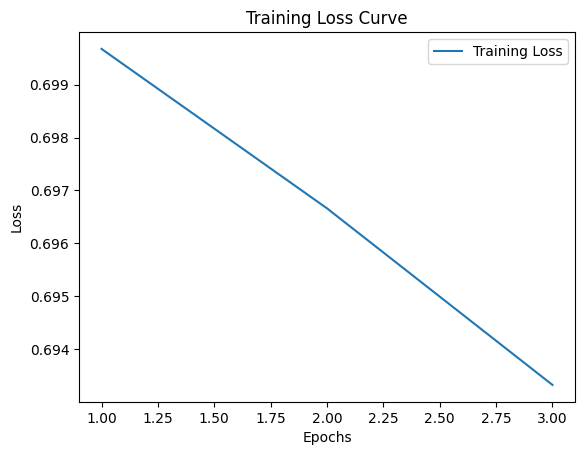

In [6]:
# Plot the training loss curve
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

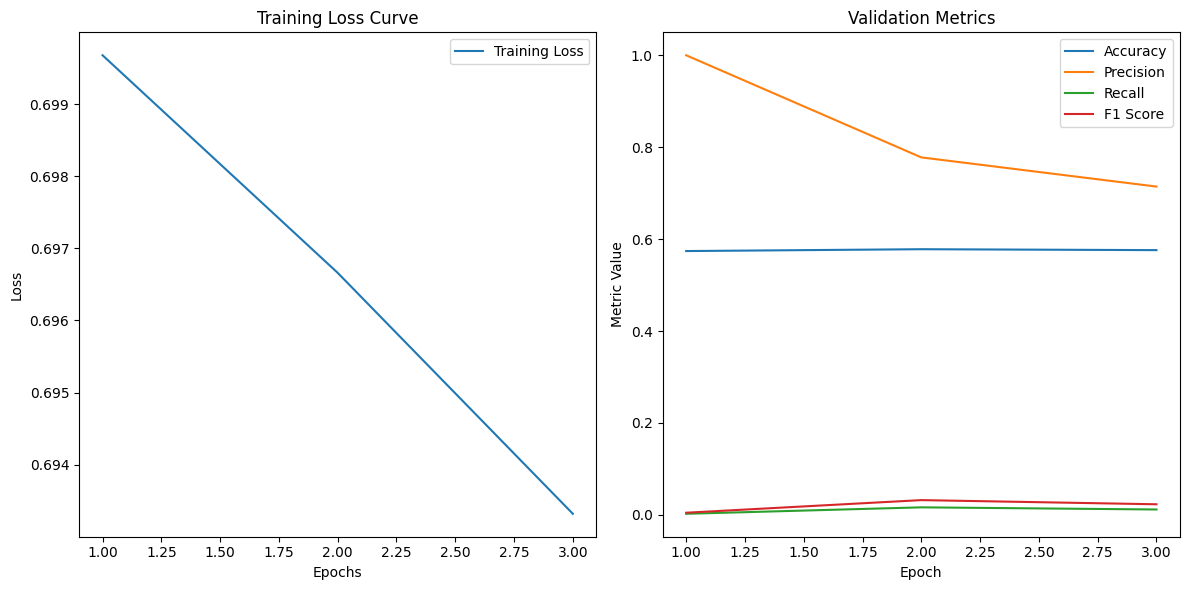

In [7]:
# Plot metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies, label='Accuracy')
plt.plot(range(1, epochs + 1), precisions, label='Precision')
plt.plot(range(1, epochs + 1), recalls, label='Recall')
plt.plot(range(1, epochs + 1), f1_scores, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title("Validation Metrics")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
# Saving the model
model.save_pretrained('./bangla_bert_hate_detection')
tokenizer.save_pretrained('./bangla_bert_hate_detection')

# To load the saved model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained('./bangla_bert_hate_detection')
tokenizer = AutoTokenizer.from_pretrained('./bangla_bert_hate_detection')


Saving the Model with Pickle

In [9]:
import pickle

# Save the model using pickle
with open('bangla_bert_hate_detection_model.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f)

# Save the tokenizer (if needed)
with open('bangla_bert_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

Loading the Model with Pickle

In [10]:
import pickle

# Load the model
with open('bangla_bert_hate_detection_model.pkl', 'rb') as f:
    model_state_dict = pickle.load(f)

# Initialize the model and load the state_dict
model = AutoModelForSequenceClassification.from_pretrained("sagorsarker/bangla-bert-base", num_labels=2)
model.load_state_dict(model_state_dict)
model.to(device)

# Load the tokenizer
with open('bangla_bert_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
